***Домашнее задание #4. Применение бертоподобных моделей к задаче классификации***

Решите задачу классификации по тональности на подготовленном в тетрадке корпусе, используя пайплайн с Trainer  от HuggingFace. 



2. измените модель, чтобы помимо выхода с пуллер-слоя использовался  эмбеддинг  cls-токена с последнего слоя. -- 3 балла 


In [1]:
!pip install -q -U watermark

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 2.1.3 which is incompatible.


In [2]:
!pip install transformers

     |████████████████████████████████| 3.8 MB 5.2 MB/s 
     |████████████████████████████████| 6.5 MB 30.9 MB/s 
     |████████████████████████████████| 895 kB 35.6 MB/s 
     |████████████████████████████████| 596 kB 43.0 MB/s 
     |████████████████████████████████| 67 kB 4.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.7.12
IPython version      : 5.5.0

numpy       : 1.21.5
pandas      : 1.3.5
torch       : 1.10.0+cu111
transformers: 4.17.0



In [4]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 34.8MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
100% 7.17M/7.17M [00:00<00:00, 86.9MB/s]


In [5]:
import transformers
from transformers import BertModel, AutoTokenizer, BertTokenizer, PreTrainedTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch.nn.functional as F

import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader

In [6]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 6

Повторяем то же самое, что делали в прошлой тетрадке:

In [7]:
RANDOM_SEED = 1
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("reviews.csv")

In [10]:
def to_sentiment(rating):
  rating = int(rating)
  if rating <= 2:
    return 0
  elif rating == 3:
    return 1
  else: 
    return 2

df['sentiment'] = df.score.apply(to_sentiment)

In [11]:
class_names = ['negative', 'neutral', 'positive']

In [12]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
X = list(df["content"])
y = list(df["sentiment"])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

X_train_tokenized = tokenizer(X_train, padding=True, truncation=True, max_length=160)
X_test_tokenized = tokenizer(X_test, padding=True, truncation=True, max_length=160)
X_val_tokenized = tokenizer(X_val, padding=True, truncation=True, max_length=160)

In [14]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])   
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [15]:
def create_data_loader(X, y, batch_size):
  ds = Dataset(X, y)

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=1
  )

In [16]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
train_data_loader = create_data_loader(X_train_tokenized, y_train, 16)
val_data_loader = create_data_loader(X_val_tokenized, y_val, 16)

In [35]:
test_data_loader = create_data_loader(X_test_tokenized, y_test, 16)

Делаем кастомный классификатор на берте: поскольку в задании указано использовать эмбеддинг cls-токена с последнего слоя, то мы определяяем его cls_emdeddings, затем конкатенируем с пуллер-слоем и уже делаем классификацию.Маша сказала, что конкатенация здесь уместна.

In [24]:
class CustomSentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super().__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size*2, n_classes)

  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False)
    cls_embeddings = last_hidden_state[:,0,:]
    merged = torch.cat((cls_embeddings,pooled_output),dim=-1)
    output = self.drop(merged)
    return self.out(merged)

In [25]:
model = CustomSentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [28]:
#как заморозить отдельные слои
freeze_layers = list(range(5))
for layer_id in freeze_layers:
  for param in list(model.bert.encoder.layer[layer_id].parameters()):
    param.requires_grad = False

In [29]:
EPOCHS = 2

#optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [30]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["labels"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    preds = torch.argmax(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions / n_examples, np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions / n_examples, np.mean(losses)

In [32]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(X_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(X_val)
  )

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/2
----------
Train loss 0.7056932500132589 accuracy 0.6816738843917847
Val loss 0.5469722059369088 accuracy 0.756035566329956

Epoch 2/2
----------
Train loss 0.44430656454464923 accuracy 0.8249947428703308
Val loss 0.4905990467965603 accuracy 0.8106734156608582

CPU times: user 17min 43s, sys: 4min 33s, total: 22min 17s
Wall time: 23min 15s


In [33]:
history['train_acc'] = [score.to('cpu') for score in  history['train_acc']]
history['val_acc'] = [score.to('cpu') for score in  history['val_acc']]

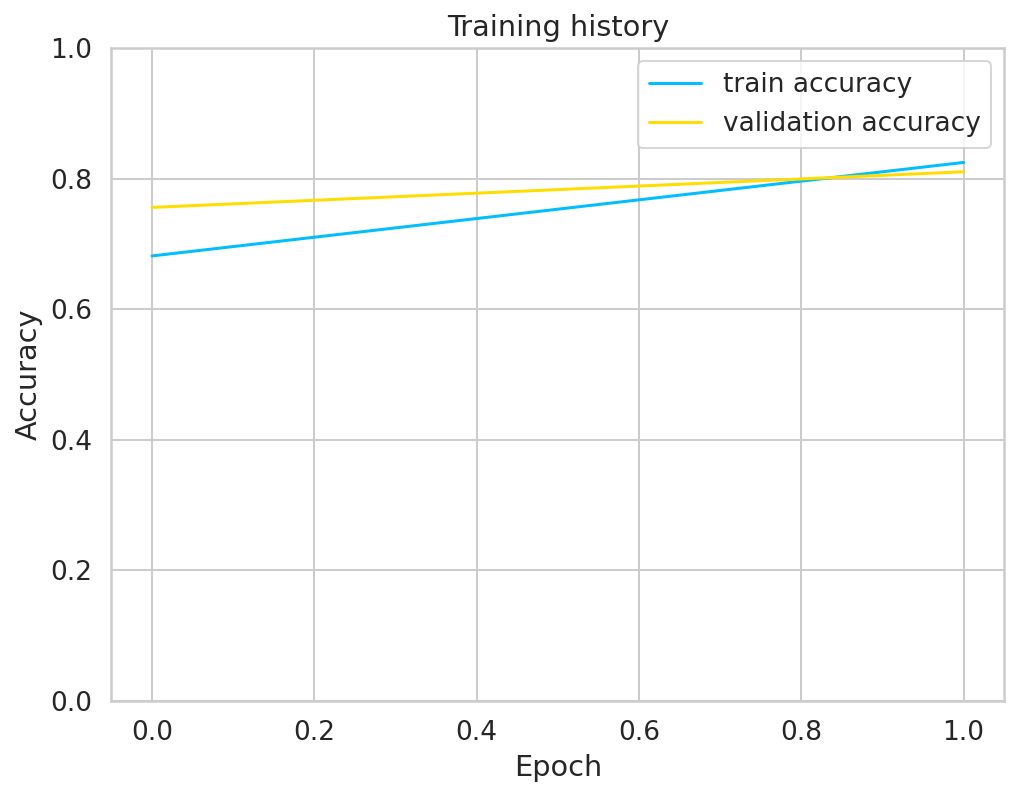

In [34]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

Теперь сделаем предсказания на тесте:

In [36]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(X_test)
)

test_acc.item()

0.7817258834838867

In [62]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["labels"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      preds = torch.argmax(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return predictions, prediction_probs, real_values

In [63]:
y_pred, y_pred_probs, y_test = get_predictions(model, test_data_loader)

In [43]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.82      0.78      0.80       266
     neutral       0.66      0.74      0.70       235
    positive       0.87      0.82      0.84       287

    accuracy                           0.78       788
   macro avg       0.78      0.78      0.78       788
weighted avg       0.79      0.78      0.78       788



Также возьмем четыре отзыва из гугл-плей:

The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go

Оценка на гугл-плей: 2

Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player.

Оценка на гугл-плей: 5

Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race.

Оценка на гугл-плей: 1

The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete.

Оценка на гугл-плей: 3

In [44]:
first_review = "The whole game is ruined with the PR system. You upgrade parts and the PR doesn't increase? You win mystery parts but never get what you need and it just wastes the days on special events so they never get completed! I know you want to make money but you've ruined what could potentially be a very go"

In [45]:
second_review = "Good game. Please add multiplayer mode so we can play with friends. It will be much fun if we can play with our friendlist than random live player."

In [46]:
third_review = "Convoluted rewards and parts system. The game is far too difficult to setup and understand before you can get to a race. A never-ending confusion of terms such as money, gold, parts, black market, etc. Gone are the days when NFS was just about selecting a car and selecting a track to race on. On the PC it was an amazing experience until NFS MW. Now it's just all monetized garbage and again, hate to say it again, VERY complicated to understand how to start a race."

In [77]:
forth_review = "The reason I'm giving three stars to this game. It's because of its VIP in game system. You purchased bundle pack on the game and it throws out Ads. Every time you a win race in the game. Majority of the games I play don't shows Ads after you purchased a pack or bundle. The fuel system in this game so I can play more into this game is somewhat lacking. It should of gave you additional tickets for the other races like those you have a certain time to complete."

In [69]:
def clean_pred(model, text):
  text_tokenized = tokenizer(text, padding=True, truncation=True, max_length=160)
  model = model.eval()
    

  with torch.no_grad():
    input_ids = torch.tensor(text_tokenized["input_ids"]).to(device)
    attention_mask = torch.tensor(text_tokenized["attention_mask"]).to(device)

    input_ids = input_ids.reshape(1,len(input_ids))
    attention_mask = attention_mask.reshape(1,len(attention_mask))

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    preds = torch.argmax(outputs, dim=1)

    probs = F.softmax(outputs, dim=1)

    return preds

In [71]:
pred_first = clean_pred(model, first_review)
pred_first

tensor([0], device='cuda:0')

In [72]:
pred_second = clean_pred(model, second_review)
pred_second

tensor([2], device='cuda:0')

In [74]:
pred_third = clean_pred(model, third_review)
pred_third

tensor([0], device='cuda:0')

In [78]:
pred_forth = clean_pred(model, forth_review)
pred_forth

tensor([1], device='cuda:0')

Можем заметить, что модель во всех четырех случаях предсказала сентимент.

Дальше представлена моя попытка сделать то же самое с помощью трейнера, но она не увенчалась успехом:

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import TrainingArguments, Trainer
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import EarlyStoppingCallback

In [32]:
class BertForSequenceClassification(nn.Module):
  
    def __init__(self, num_labels=3):
        super(BertForSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.bert.config.hidden_size*2, num_labels)
        nn.init.xavier_normal_(self.classifier.weight)
    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        last_hidden_state, pooled_output = self.bert(
                                            input_ids=input_ids,
                                            attention_mask=attention_mask,
                                            return_dict=False)
        cls_embeddings = last_hidden_state[:,0,:]
        merged = torch.cat((cls_embeddings,pooled_output),dim=-1)
        merged_output = self.dropout(merged)
        logits = self.classifier(merged_output)
        print(logits.shape)

        return logits

In [33]:
model2 = BertForSequenceClassification(len(class_names))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred,average='weighted' )
    precision = precision_score(y_true=labels, y_pred=pred,average='weighted')
    f1 = f1_score(y_true=labels, y_pred=pred,average='weighted')

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [35]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    seed=0,
    logging_steps=300,
    load_best_model_at_end=True,
)

In [36]:
trainer = Trainer(
    model=model2,
    args=args,
    train_dataset=Dataset(X_train_tokenized, y_train),
    eval_dataset=Dataset(X_val_tokenized, y_val),
    compute_metrics=compute_metrics,
)

In [37]:
trainer.train()

***** Running training *****
  Num examples = 14171
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1772


torch.Size([16, 3])


RuntimeError: ignored